import

In [100]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

데이터를 Pandas DataFrame으로 변경

In [101]:
# CSV 파일이 저장된 디렉토리 경로
directory = '../data'

# 디렉토리 내의 모든 파일 리스트를 가져옵니다
file_list = os.listdir(directory)

# "data_"가 포함된 CSV 파일들의 경로를 저장할 리스트
csv_files = []

# 파일 리스트를 순회하면서 "data_"가 포함된 CSV 파일을 찾습니다
for file in file_list:
    if file.endswith(".csv") and "data_" in file:
        csv_files.append(os.path.join(directory, file))

# CSV 파일들을 읽어서 DataFrame으로 저장합니다
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# 결과 확인
df.head()

,No,Heartbeat,Temperature,Spo2,UserCode,GyroX,GyroY,GyroZ,Time,Label
0,1,108.0,36.6,95.0,33.0,-0.040861,4.985047,6.510526,4.960000e+13,Downstairs
1,2,109.0,36.7,99.0,33.0,-0.463092,4.372132,7.436710,4.960000e+13,Downstairs
2,3,111.0,36.6,98.0,33.0,-0.299648,4.603678,6.510526,4.960000e+13,Downstairs
3,4,108.0,36.6,97.0,33.0,-0.272407,4.481094,6.360703,4.960000e+13,Downstairs
4,5,110.0,36.6,98.0,33.0,-1.525479,5.175732,7.164303,4.960000e+13,Downstairs


학습 가능한 수준으로 빠르게 전처리

In [102]:
# 결측치 확인
df.isnull().sum()

No             0
Heartbeat      1
Temperature    1
Spo2           1
UserCode       1
GyroX          1
GyroY          1
GyroZ          2
Time           1
Label          1
dtype: int64

In [103]:
# 결측치가 삭제된 DataFrame 생성
df_cleaned = df.dropna()

In [104]:
# 결측치 삭제 확인
df_cleaned.isnull().sum()

No             0
Heartbeat      0
Temperature    0
Spo2           0
UserCode       0
GyroX          0
GyroY          0
GyroZ          0
Time           0
Label          0
dtype: int64

In [105]:
# Label 컬럼을 기준으로 라벨별 행 수 계산
Label_counts = df['Label'].value_counts()

# 라벨별 행 수 출력
print(Label_counts)

Label
Walking       406776
Jogging       325975
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44546
Name: count, dtype: int64


In [106]:
# 특성과 타겟 데이터로 분할
X = df_cleaned[['Temperature','Heartbeat','GyroX','GyroY','GyroZ']]
y = df_cleaned['Label']

In [107]:
from imblearn.under_sampling import RandomUnderSampler

# 'Standing' 클래스의 샘플 수
standing_count = 44000

# 언더샘플링 객체 생성
rus = RandomUnderSampler(sampling_strategy={'Walking': standing_count, 'Jogging': standing_count, 'Upstairs': standing_count,
                                           'Downstairs': standing_count, 'Sitting': standing_count})

# 언더샘플링 적용
X_resampled, y_resampled = rus.fit_resample(X, y)

# 테스트 세트와 트레인 세트로 분할 (70% 트레인, 30% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=7)


In [108]:
# 테스트 세트와 트레인 세트로 분할 (70% 트레인, 30% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=7)

# 결과 확인
print("X_train:")
print(X_train)
print("y_train:")
print(y_train)
print("X_test:")
print(X_test)
print("y_test:")
print(y_test)

X_train:
        Temperature  Heartbeat     GyroX      GyroY     GyroZ
138254         36.5      140.0 -0.690000   9.700000  1.460000
110246         36.6      128.0  1.380000  -0.040000  9.660000
16234          36.5      109.0  0.926184   8.812365  2.152015
154920         36.7      141.0 -1.270000   9.660000  2.560000
208062         36.7      129.0  9.770000   6.210000 -0.500000
...             ...        ...       ...        ...       ...
235075         36.6      134.0  3.530000  14.210000  3.636633
10742          36.5      109.0 -4.750000  12.340000  1.840000
49689          36.6      133.0  8.080000   9.040000 -2.530000
189636         36.6      141.0  0.110000   6.820000 -3.760000
61615          36.7      129.0  5.710000  -8.580000  1.230000

[185182 rows x 5 columns]
y_train:
138254      Standing
110246       Sitting
16234     Downstairs
154920      Standing
208062      Upstairs
             ...    
235075       Walking
10742     Downstairs
49689        Jogging
189636      Upstairs
6

In [121]:
# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, '../model/scaler_knn.pkl')

['../model/scaler_knn.pkl']

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import joblib

# 전처리에 사용된 scaler 객체 생성 및 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# KNN 모델 학습
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

# 모델 저장
model_file = "../model/model_knn.pkl"
joblib.dump(knn, model_file)

# scaler 객체 저장
scaler_file = "../model/scaler_knn.pkl"
joblib.dump(scaler, scaler_file)


['../model/scaler_knn.pkl']

독립변수, 종속변수 설정

In [110]:
# 독립변수, 종속변수 설정
X = X_train
y = y_train
print("독립변수 X : ", X)
print("종속변수 Y : ", y)

독립변수 X :  [[-1.96051867  0.90343549 -0.22773506  0.44503101  0.01774704]
 [-0.78355665 -0.28369406  0.13309406 -1.22308727  1.78716403]
 [-1.96051867 -2.16331584  0.05398771  0.29301045  0.16707181]
 ...
 [-0.78355665  0.21094325  1.30099509  0.3319963  -0.84322537]
 [-0.78355665  1.00236295 -0.08828419 -0.04821136 -1.10863791]
 [ 0.39340538 -0.1847666   0.88787189 -2.68568789 -0.03188294]]
종속변수 Y :  138254      Standing
110246       Sitting
16234     Downstairs
154920      Standing
208062      Upstairs
             ...    
235075       Walking
10742     Downstairs
49689        Jogging
189636      Upstairs
61615        Jogging
Name: Label, Length: 185182, dtype: object


독립변수 : 체온, 맥박, 자이로스코프 x,y,z축
종속변수 : 활동 레이블

선형 모델을 기반으로 한 모델 생성

In [111]:
kernal_evals = dict() # 모델 평가 결과를 저장할 딕셔너리

# 모델을 평가, 결과를 출력, kernal_evals 딕셔너리에 저장
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='micro')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='micro')
    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='micro')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='micro')
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall,
                               test_recall]
    print(f"Training Accuracy {name} is {train_accuracy * 100},  Test Accuracy {name} is {test_accuracy * 100}")
    print(f"Training Precesion {name} is {train_precision * 100},  Test Accuracy {name} is {test_precision * 100}")
    print(f"Training Recall {name} is {train_recall * 100},  Test Accuracy {name} is {test_recall * 100}")

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                                display_labels=['LAYING', 'SITTING', 'STANDING', 'WALKING',
                                                                'DOWNSTAIRS', 'UPSTAIRS'])
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Training Accuracy Logistic Regression is 59.4372023198799,  Test Accuracy Logistic Regression is 59.63031097222922
Training Precesion Logistic Regression is 59.4372023198799,  Test Accuracy Logistic Regression is 59.63031097222922
Training Recall Logistic Regression is 59.4372023198799,  Test Accuracy Logistic Regression is 59.63031097222922


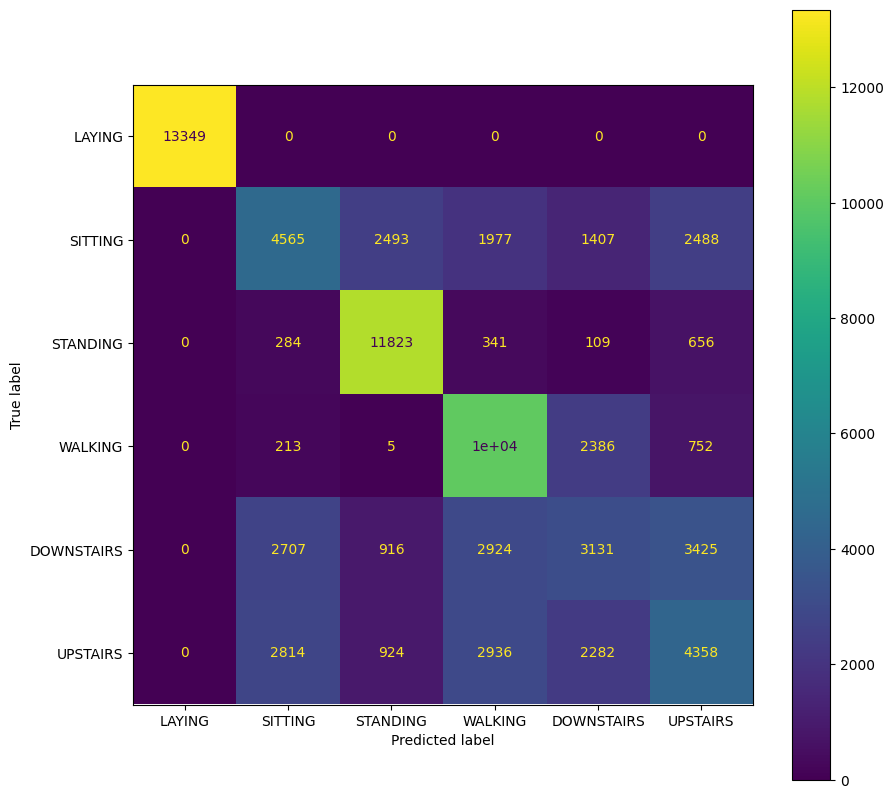

In [113]:
lr = LogisticRegression().fit(X_train, y_train)
evaluate_classification(lr, "Logistic Regression", X_train, X_test, y_train, y_test)

Training Accuracy LinearDiscriminantAnalysis is 59.07431607823654,  Test Accuracy LinearDiscriminantAnalysis is 59.2976664482637
Training Precesion LinearDiscriminantAnalysis is 59.07431607823654,  Test Accuracy LinearDiscriminantAnalysis is 59.2976664482637
Training Recall LinearDiscriminantAnalysis is 59.07431607823654,  Test Accuracy LinearDiscriminantAnalysis is 59.2976664482637


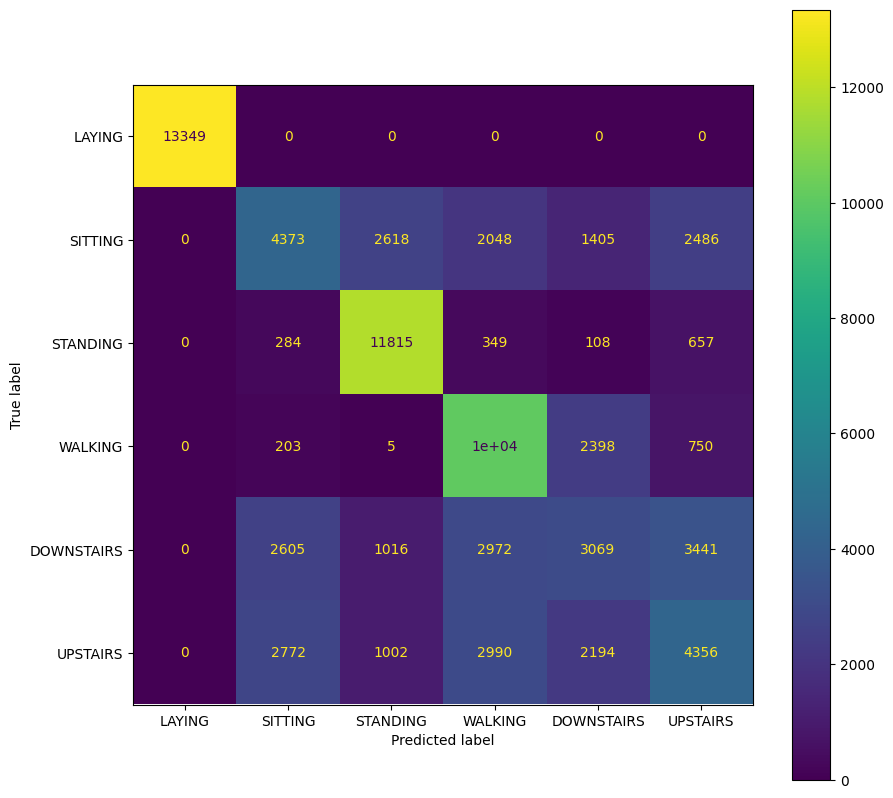

In [114]:
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
evaluate_classification(lda, "LinearDiscriminantAnalysis", X_train, X_test, y_train, y_test)

In [97]:
# 클래스 인코딩
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_test = label_encoder.transform(y_test)

# class_mapping = {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
# y_train = y_train.map(class_mapping)
# y_test = y_test.map(class_mapping)

import pandas as pd

# 판다스 Series로 변환
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# # 클래스 인코딩 매핑 적용
# class_mapping = {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
# y_train = y_train.map(class_mapping)
# y_test = y_test.map(class_mapping)

Training Accuracy KNeighborsClassifier is 77.02854489097213,  Test Accuracy KNeighborsClassifier is 75.33264452396553
Training Precesion KNeighborsClassifier is 77.02854489097213,  Test Accuracy KNeighborsClassifier is 75.33264452396553
Training Recall KNeighborsClassifier is 77.02854489097213,  Test Accuracy KNeighborsClassifier is 75.33264452396553


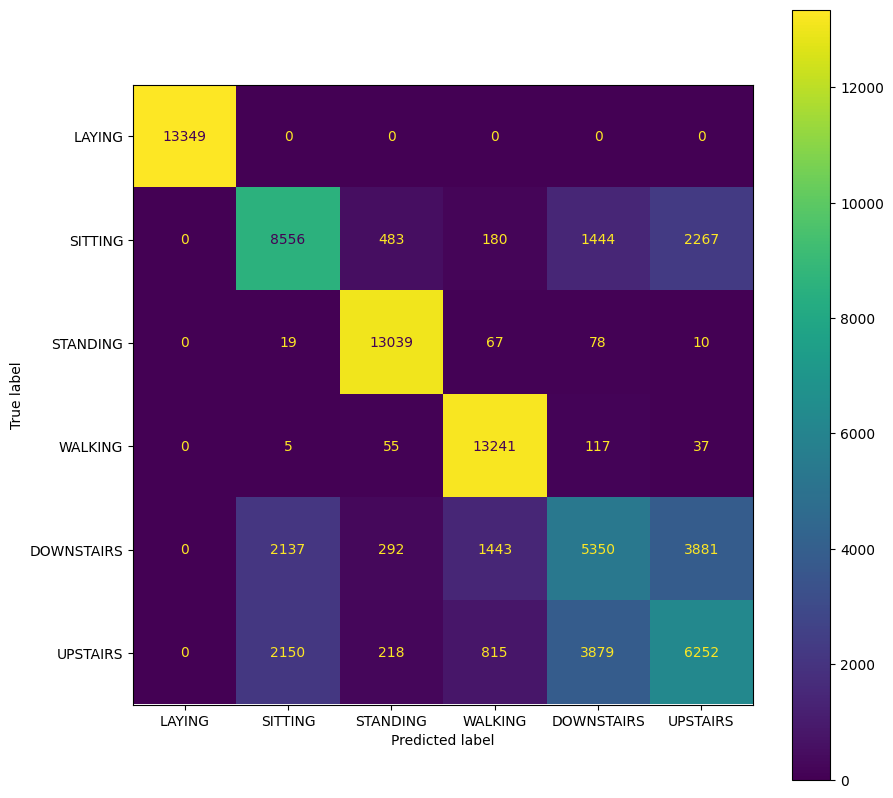

In [115]:
knn = KNeighborsClassifier(n_neighbors=30).fit(X_train, y_train)
evaluate_classification(knn, "KNeighborsClassifier", X_train, X_test, y_train, y_test)

In [120]:
model_knn = knn
joblib.dump(model_knn, '../model/model_knn.pkl')

['../model/model_knn.pkl']

Training Accuracy GaussianNB is 66.57234504433475,  Test Accuracy GaussianNB is 66.98755103069402
Training Precesion GaussianNB is 66.57234504433475,  Test Accuracy GaussianNB is 66.98755103069402
Training Recall GaussianNB is 66.57234504433475,  Test Accuracy GaussianNB is 66.98755103069402


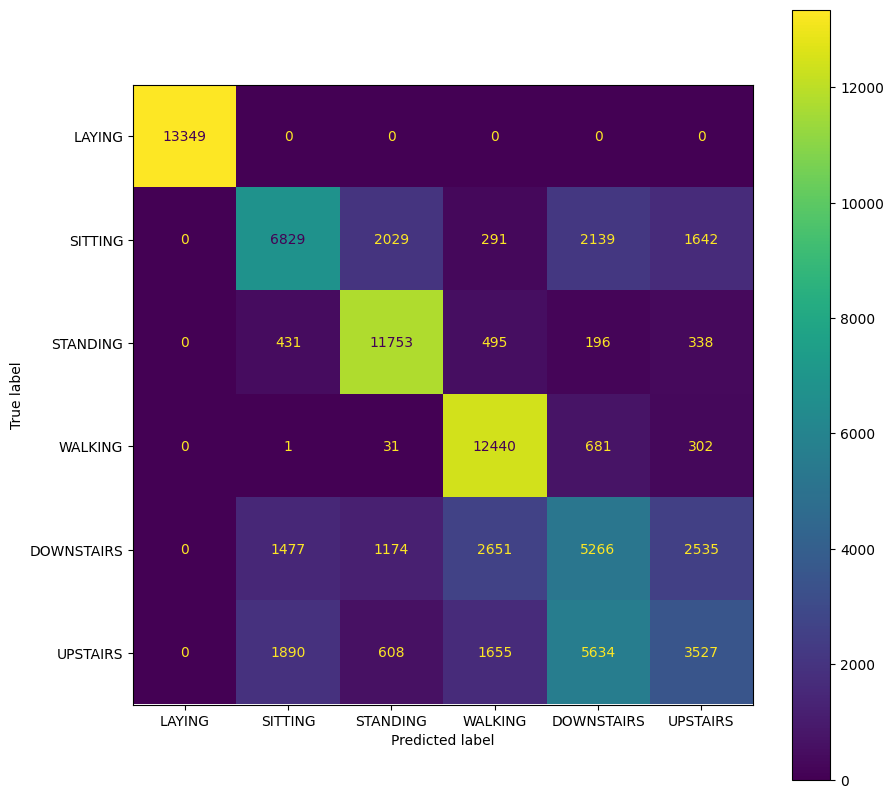

In [116]:
gnb = GaussianNB().fit(X_train, y_train)
evaluate_classification(gnb, "GaussianNB", X_train, X_test, y_train, y_test)

D:\Danu\Project\venv2\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training Accuracy Linear SVC(LBasedImpl) is 57.47048849240207,  Test Accuracy Linear SVC(LBasedImpl) is 57.82344639887103
Training Precesion Linear SVC(LBasedImpl) is 57.47048849240207,  Test Accuracy Linear SVC(LBasedImpl) is 57.82344639887103
Training Recall Linear SVC(LBasedImpl) is 57.47048849240207,  Test Accuracy Linear SVC(LBasedImpl) is 57.82344639887103


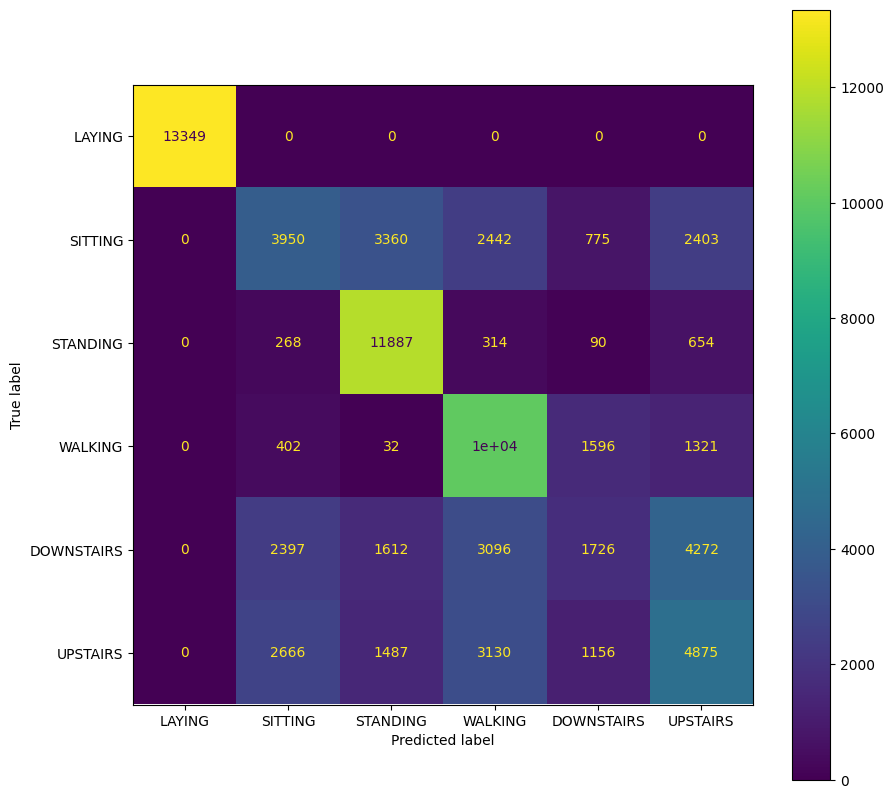

In [117]:
lin_svc = svm.LinearSVC().fit(X_train, y_train)
evaluate_classification(lin_svc, "Linear SVC(LBasedImpl)", X_train, X_test, y_train, y_test)

Training Accuracy RBF SVC is 73.31004093270404,  Test Accuracy RBF SVC is 73.38591804848545
Training Precesion RBF SVC is 73.31004093270404,  Test Accuracy RBF SVC is 73.38591804848545
Training Recall RBF SVC is 73.31004093270404,  Test Accuracy RBF SVC is 73.38591804848545


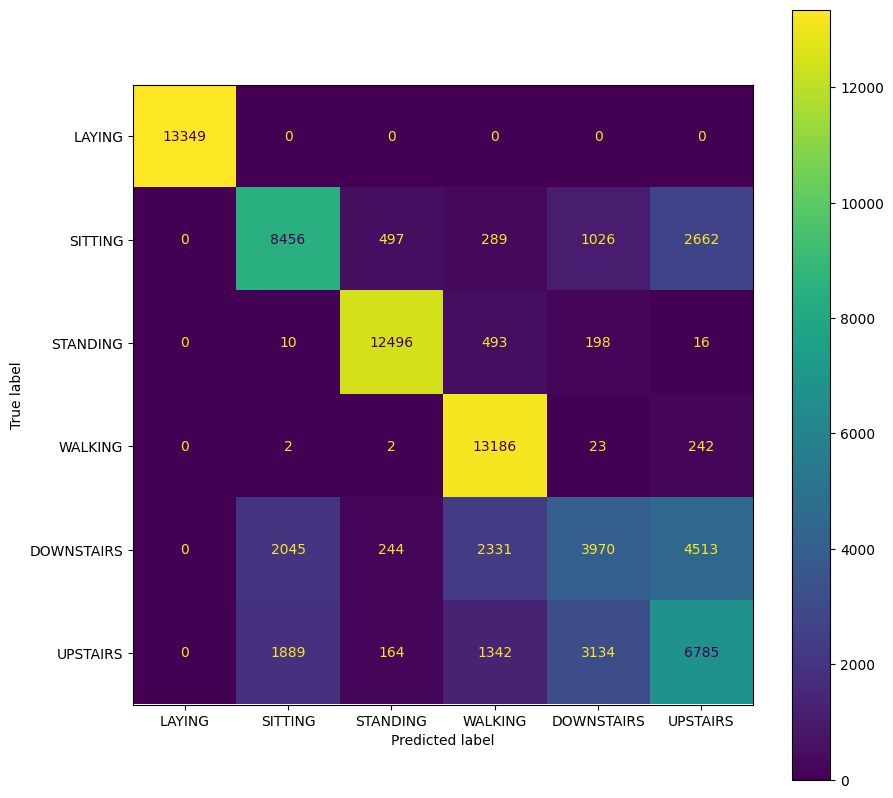

In [118]:
rbf = svm.SVC(kernel='rbf').fit(X_train, y_train)
evaluate_classification(rbf, "RBF SVC", X_train, X_test, y_train, y_test)

In [98]:
# # XGBoost 모델 생성
# model = xgb.XGBClassifier()
#
# # 모델 학습
# model.fit(X, y)

# XGBoost 모델 생성 (objective 매개변수 설정)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=6)

# 모델 학습
model.fit(X, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [99]:
# 모델 평가
y_pred = model.predict(X_test)

def get_clf_eval(test, pred):
    confusion = confusion_matrix(test, pred)
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred, average='weighted')
    recall = recall_score(test, pred, average='weighted')
    f1 = f1_score(test, pred, average='weighted')
    print('오차 행렬')
    print(confusion)
    print('Accuracy:', accuracy, 'precision:', precision, 'recall:', recall, 'f1:', f1)

get_clf_eval(y_test, y_pred)

# classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

오차 행렬
[[13349     0     0     0     0     0]
 [    0  8760    76    64  1388  2642]
 [    0    46 12980    59   104    24]
 [    0     7     9 13105   256    78]
 [    0  2190    56   684  5787  4386]
 [    0  2013    34   336  3752  7179]]
Accuracy: 0.770626480520135 precision: 0.7668697303531177 recall: 0.770626480520135 f1: 0.7680645218684895
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13349
           1       0.67      0.68      0.68     12930
           2       0.99      0.98      0.98     13213
           3       0.92      0.97      0.95     13455
           4       0.51      0.44      0.47     13103
           5       0.50      0.54      0.52     13314

    accuracy                           0.77     79364
   macro avg       0.77      0.77      0.77     79364
weighted avg       0.77      0.77      0.77     79364

